In [1]:
import copy
import math
import time
import numpy as np
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
import my
import lenet
import resnet

In [2]:
class Args:
    pass
args = Args()

args.actor_iterations = 100
args.c_batch_size = 8
args.critic_batch_size = 8
args.critic_iterations = 25
args.master_gpu = 2
args.n_iterations = 250
args.n_perturbations = 100
args.sample_size = 50
args.slave_gpu = ''
args.std = 1e-1
args.tau = 1e-1

verbose = None

In [3]:
cuda = args.master_gpu >= 0
if cuda:
    th.cuda.set_device(args.master_gpu)

th.random.manual_seed(1)
if cuda:
    th.cuda.manual_seed_all(1)

train_x, train_y, test_x, test_y = my.load_cifar10(rbg=True, torch=True)
# train_x, train_y, test_x, test_y = my.load_cifar10(rbg=False, torch=True)

train_set = TensorDataset(train_x, train_y)
train_loader = DataLoader(TensorDataset(train_x, train_y), 4096, drop_last=False)
test_loader = DataLoader(TensorDataset(test_x, test_y), 4096, drop_last=False)

n_classes = int(train_y.max() - train_y.min() + 1)

In [4]:
def forward(c, xy):
    x, y = xy
    y = my.onehot(y, n_classes)
    y_bar = F.softmax(c(x), 1)
    return th.cat((y, y_bar), 1).view(1, -1)

def L_global(c, loader):
    return my.global_stats(c, loader, lambda y_bar, y: my.nd_f_beta(y_bar, y, n_classes))

def L_mini_batch(c, loader):
    L_list = [my.nd_f_beta(th.max(c(x), 1)[1], y, n_classes).view(1, 1) for x, y in loader]
    return th.cat(L_list, 0)

In [5]:
# c = my.MLP((3072, n_classes), F.relu)
# c = my.MLP((3072,) + (1024,) + (n_classes,), F.relu)
# c = my.MLP((3072,) + (1024,) * 2 + (n_classes,), F.relu)
# c = my.MLP((3072,) + (1024,) * 3 + (n_classes,), F.relu)
# c = lenet.LeNet(3, n_classes)
c = resnet.ResNet(depth=18, n_classes=n_classes)

critic = my.RN(args.sample_size, 2 * n_classes, tuple(), (4 * n_classes, 64, 256), (256, 64) + (1,), F.relu, triu=True)

if cuda:
    c.cuda()
    critic.cuda()
    if args.slave_gpu:
        slave_gpu = tuple(map(int, args.slave_gpu.split(',')))
        critic = nn.DataParallel(critic, slave_gpu, args.master_gpu)

c_optim = Adam(c.parameters(), eps=1e-3)
critic_optim = Adam(critic.parameters())

print('initial f1: %f' % L_global(c, test_loader))

initial f1: 0.060979


In [ ]:
hist = []
s_critic = my.sample(train_set, args.sample_size, args.critic_batch_size, cuda)
for i in range(args.n_iterations):
    hist.append({})
#     hist[-1]['critic_state_dict'] = copy.deepcopy(my.state_dict_gpu2cpu(critic.state_dict()))        
#     hist[-1]['critic_optim_state_dict'] = my.optim_state_dict_gpu2cpu(critic_optim.state_dict())
#     hist[-1]['c_state_dict'] = copy.deepcopy(my.state_dict_gpu2cpu(c.state_dict()))
#     hist[-1]['c_optim_state_dict'] = my.optim_state_dict_gpu2cpu(c_optim.state_dict())

    if verbose == 0:
        t0 = time.time()

#     if i % 0 == 0:
#         s_critic = my.sample(train_set, args.sample_size, args.critic_batch_size, cuda)

    L_c = L_mini_batch(c, s_critic)
    c_bar_list = []
    L_bar_list = []
    t_list = []
    for j in range(args.n_perturbations):
        c_bar_list.append(my.perturb(c, args.std))
        L_bar = L_mini_batch(c_bar_list[-1], s_critic)
        L_bar_list.append(L_bar)
        t_list.append(L_c - L_bar)
    w_list = th.cat([th.exp(t**2 / args.tau) for t in t_list], 1)
    w_list = th.chunk((w_list / th.sum(w_list, 1, keepdim=True)).detach(), args.n_perturbations, 1)

    hist[-1]['L_bar_list'] = L_bar_list
    hist[-1]['w_list'] = w_list

    if verbose == 0:
        t1 = time.time()
        print('[iteration %d]t1 - t0: %f' % (i + 1, t1 - t0))
            
    y = th.cat([forward(c, xy) for xy in s_critic], 0).detach()
    y_bar_list = [th.cat([forward(c_bar, xy) for xy in s_critic], 0).detach() for c_bar in c_bar_list]
    for j in range(args.critic_iterations):
        for y_bar, t, w in zip(y_bar_list, t_list, w_list):
            delta = critic(y) - critic(y_bar)
            mse = th.sum(w * (t - delta)**2)
            critic_optim.zero_grad()
            mse.backward()
            critic_optim.step()
#     assert not my.module_isnan(critic)

    if verbose == 0:
        t2 = time.time()
        print('[iteration %d]t2 - t1: %f' % (i + 1, t2 - t1))

    c_param = copy.deepcopy(tuple(c.parameters()))
    for j in range(args.actor_iterations):
        s = s_critic + my.sample(train_set, args.sample_size, args.c_batch_size, cuda)
        y_bar = th.cat([forward(c, xy) for xy in s], 0)
        objective = -th.mean(critic(y_bar))
        c_optim.zero_grad()
        objective.backward()
        c_optim.step()
        if any(float(th.max(th.abs(p - q))) > args.std for p, q in zip(c_param, c.parameters())):
            break
#     assert not my.module_isnan(c)

    if verbose == 0:
        t3 = time.time()
        print('[iteration %d]t3 - t2: %f' % (i + 1, t3 - t2))

#     f1 = th.mean(L_mini_batch(c, s_critic))
#     hist[-1]['f1'] = float(f1)

    global_f1 = L_global(c, test_loader)
    hist[-1]['global_f1'] = float(global_f1)
    
    if (i + 1) % 1 == 0:
        print('[iteration %d]global f1: %f' % (i + 1, global_f1))
#         print('[iteration %d]f1: %f; global f1: %f' % (i + 1, f1, global_f1))

In [8]:
import matplotlib.pylab as pl
%matplotlib inline

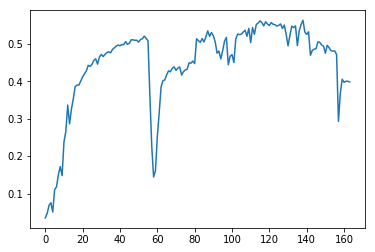

In [9]:
pl.plot(range(len(hist)), [h['global_f1'] for h in hist])

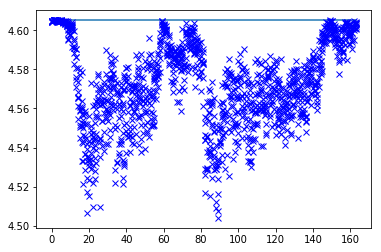

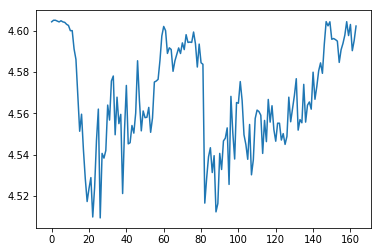

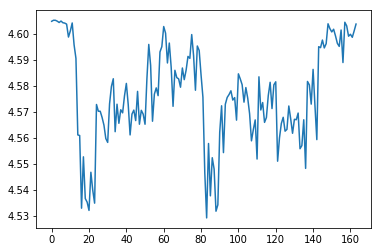

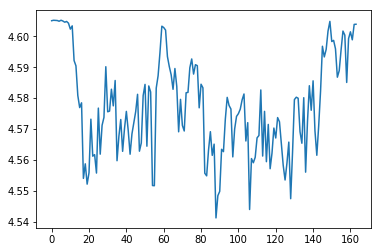

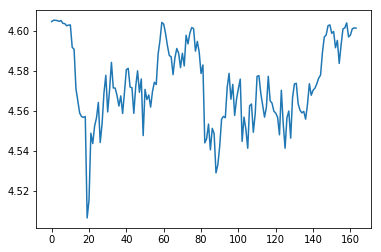

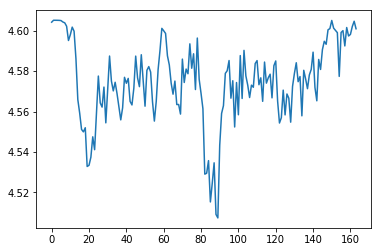

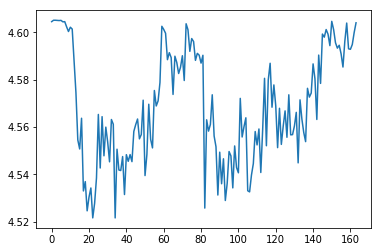

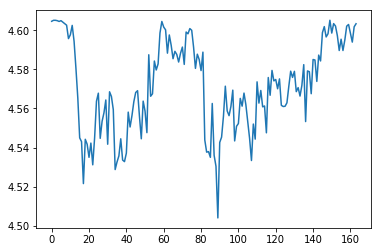

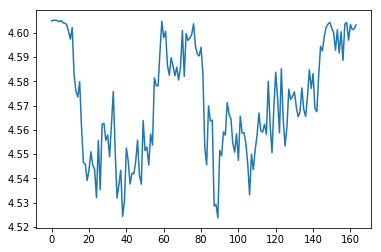

In [11]:
pl.plot(range(len(hist)), (-math.log(1 / args.n_perturbations),) * len(hist))
entropy_list = []
for i, h in enumerate(hist):
    w_list = th.cat(h['w_list'], 1)
    entropy_list.append(-th.sum(w_list * th.log(w_list), 1))
    pl.plot((i,) * args.critic_batch_size, entropy_list[-1].data.cpu().numpy(), 'bx')

tolist = lambda x: th.cat(x, 1).data.cpu().numpy().flatten()

for i in range(args.critic_batch_size):
    pl.figure()
    pl.plot(range(len(hist)), tolist([e[i : i + 1].view(1, 1) for e in entropy_list]))

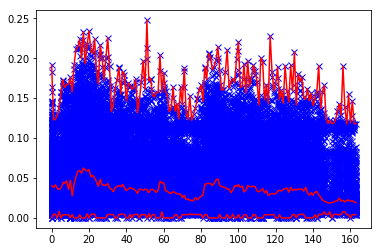

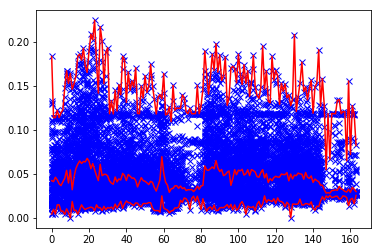

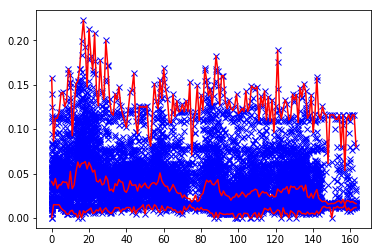

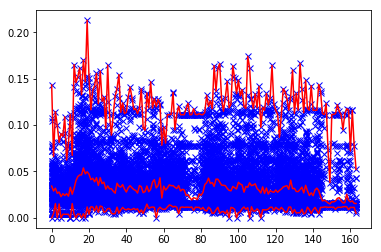

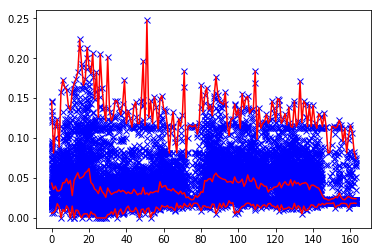

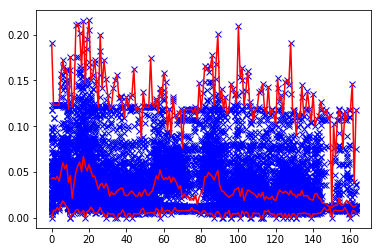

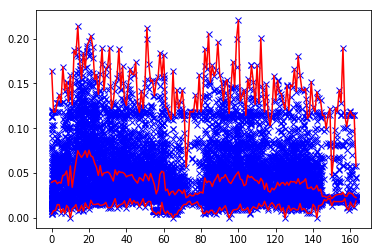

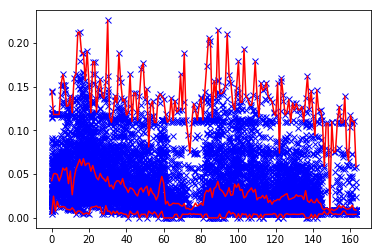

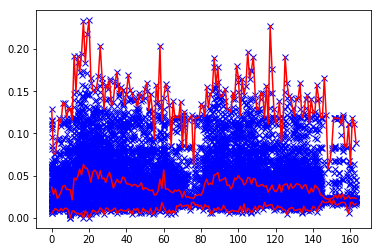

In [12]:
x = sum(([i] * args.critic_batch_size * args.n_perturbations for i in range(len(hist))), [])
y = th.cat([th.cat(h['L_bar_list'], 0) for h in hist], 0).cpu().numpy()
pl.plot(x, y, 'bx')

L_bar_list = [th.cat(h['L_bar_list'], 1) for h in hist]

pl.plot(range(len(hist)), [th.min(L_bar).item() for L_bar in L_bar_list], 'r')
pl.plot(range(len(hist)), [th.max(L_bar).item() for L_bar in L_bar_list], 'r')
pl.plot(range(len(hist)), [th.mean(L_bar).item() for L_bar in L_bar_list], 'r')

for i in range(args.critic_batch_size):
    pl.figure()
    x = sum(([i] * args.n_perturbations for i in range(len(hist))), [])
    y = th.cat([L_bar[i] for L_bar in L_bar_list], 0).cpu().numpy()
    pl.plot(x, y, 'bx')
    pl.plot(range(len(hist)), [th.min(L_bar, 1)[0][i].item() for L_bar in L_bar_list], 'r')
    pl.plot(range(len(hist)), [th.max(L_bar, 1)[0][i].item() for L_bar in L_bar_list], 'r')
    pl.plot(range(len(hist)), [th.mean(L_bar, 1)[i].item() for L_bar in L_bar_list], 'r')

In [ ]:
env_dict = {'c_bar_list' : c_bar_list, 'L_bar_list' : L_bar_list, 't_list' : t_list, 'w_list' : w_list}

In [ ]:
# visualize gradient

h = hist[-1]
c, c_bar = CNN(n_classes), CNN(n_classes)
c.load_state_dict(my.state_dict_cpu2gpu(h['c_state_dict']))
c_bar.load_state_dict(h['c_state_dict'])
critic = my.RN(args.sample_size, 2 * n_classes, (32, 64), (64,) * 1 + (1,), F.relu)
critic.load_state_dict(state_dict_strip(my.state_dict_cpu2gpu(h['critic_state_dict'])))
if cuda:
    c.cuda()
    c_bar.cuda()
    critic.cuda()

y_bar = th.cat([forward(c, xy) for xy in s], 0)
objective = -th.mean(critic(y_bar))
objective.backward()

for i in range(args.batch_size):
    alpha = np.linspace(0, 1)
    f1_list = []
    critic_list = []
    for a in alpha:
        for p, p_bar in zip(c.parameters(), c_bar.parameters()):
            p_bar.data = p.data - float(a) * p.grad.data
        f1_list.append(float(L_mini_batch(c_bar, s)[i]))
        y_bar = th.cat([forward(c_bar, xy) for xy in s], 0)
        critic_list.append(float(critic(y_bar)[i]))
    
    f1_arr = np.array(f1_list)
    critic_arr = np.array(critic_list)
    pl.figure()
    pl.plot(alpha, f1_arr)
    pl.plot(alpha, critic_arr - critic_arr[0] + f1_arr[0])

In [ ]:
# train critic one more step

c.load_state_dict(my.state_dict_cpu2gpu(hist[-1]['c_state_dict']))
critic.load_state_dict(my.state_dict_cpu2gpu(hist[-1]['critic_state_dict']))

critic_optim = Adam(critic.parameters(), 1e-3)
critic_optim.load_state_dict(optim_state_dict_cpu2gpu(hist[-1]['critic_optim_state_dict']))

y = th.cat([forward(c, xy) for xy in s], 0).detach()
# TODO "s"!
y_bar_list = [th.cat([forward(c_bar, xy) for xy in s], 0).detach() for c_bar in env_dict['c_bar_list']]
for j in range(args.critic_iterations):
    for y_bar, t, w in zip(y_bar_list, env_dict['t_list'], env_dict['w_list']):
        delta = critic(y) - critic(y_bar)
        mse = th.sum(w * (t - delta)**2)
        critic_optim.zero_grad()
        mse.backward()
        critic_optim.step()
        assert not module_isnan(critic)

In [ ]:
# train c one more step

h = hist[-2]

c.load_state_dict(my.state_dict_cpu2gpu(h['c_state_dict']))
critic.load_state_dict(my.state_dict_cpu2gpu(h['critic_state_dict']))
c_optim = Adam(c.parameters(), 1e-3)
c_optim.load_state_dict(optim_state_dict_cpu2gpu(h['c_optim_state_dict']))

c_param = copy.deepcopy(tuple(c.parameters()))
for j in range(args.actor_iterations):
    y_bar = th.cat([forward(c, xy) for xy in s], 0) # TODO "s"!
    objective = -th.mean(critic(y_bar))
    c_optim.zero_grad()
    objective.backward()
    c_optim.step()
    if any(float(th.max(th.abs(p - q))) > args.std for p, q in zip(c_param, c.parameters())):
        break

f1 = th.mean(L_mini_batch(c, s))
float(f1)